In [1]:
import os 
import sys
import itertools
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from tqdm.notebook import tqdm
from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, roc_curve
import bz2
import lzma
import json
from json import JSONDecodeError
from collections import Counter
import math
import pandas as pd
from matplotlib import pyplot as plt
import glob
from tqdm import tqdm
import numpy as np
import seaborn as sns

In [2]:
def read_in_bad_actors_from_tsv(in_files):
    bad_actors = defaultdict(list)
    for in_file in in_files:
        print("Reading in user politics from file: {}".format(in_file))
        with open(in_file, 'r',encoding="utf-8") as f:
            for line in f:
                if len(line)>1:
                    #print(line.split("\t"))
                    user, politics, regex_match, subreddit, created = line.split('\t')
                    entry = {'politics': politics, 'regex_match': regex_match, 'subreddit': subreddit,'created': created, 'text': ""}
                    #user, politics, subreddit, created= line.split('\t')
                    #entry = {'politics': politics, 'regex_match': "", 'subreddit': subreddit,'created': created,'text': ""}
                    bad_actors[user].append(entry)

    return bad_actors

In [3]:
# random sample 1000000 comments from integrated comments
in_file = '/shared/0/projects/reddit-political-affiliation/data/interactions/all_comments_filtered.tsv'
df_comments=pd.read_csv(in_file,header=None, names=['comment_id','parent_id','username','subreddit','created','politics','text'],sep='\t')
df_comments.drop(df_comments[df_comments['username']=='[deleted]'].index,inplace=True)
df_comments=df_comments.sample(n=1000000,random_state=42).reset_index(drop=True)

In [4]:
# read bad actors with different time span
bad_dir='/shared/0/projects/reddit-political-affiliation/data/bad-actors/'
comments_dir=bad_dir+'comments/'
bad_actors_90 = read_in_bad_actors_from_tsv([bad_dir+'bad_actors_90_days_1_flip_flop.tsv'])
print("# of bad actors: {}".format(len(bad_actors_90)))

Reading in user politics from file: /shared/0/projects/reddit-political-affiliation/data/bad-actors/bad_actors_90_days_1_flip_flop.tsv
# of bad actors: 5538


In [5]:
# remove independent users
df_bad_actors=df_comments[df_comments['username'].isin(bad_actors_90.keys())]
df_partisan=df_comments[~df_comments['username'].isin(bad_actors_90.keys())]
df_partisan=df_partisan[df_partisan['politics']!='Unknown']
bad_actor_subreddit_counts=dict(df_bad_actors['subreddit'].value_counts())
partisian_subreddit_counts=dict(df_partisan['subreddit'].value_counts())

In [6]:
def LoadCounts(word_counts, min_count=0):
    result = defaultdict(int)
    for word, count in word_counts.items():
        if count >= min_count:
              result[word] = count
    return result
  
def LoadStopwords(filename):
    stopwords = set()
    for line in open(filename):
        for word in line.split():
            if word:
                stopwords.add(word)
    return stopwords


def ComputeLogOdds(counts1, counts2, prior):
    sigmasquared = defaultdict(float)
    sigma = defaultdict(float)
    delta = defaultdict(float)

    for word in counts2.keys():
        counts1[word] = int(counts1[word] + 0.5)
        if prior[word] == 0:
            prior[word] = 1

    for word in counts1.keys():
        counts2[word] = int(counts2[word] + 0.5)
        if prior[word] == 0:
            prior[word] = 1

    n1  = sum(counts1.values())
    n2  = sum(counts2.values())
    nprior = sum(prior.values())


    for word in prior.keys():
        if prior[word] > 0:
            l1 = float(counts1[word] + prior[word]) / (( n1 + nprior ) - (counts1[word] + prior[word]))
            l2 = float(counts2[word] + prior[word]) / (( n2 + nprior ) - (counts2[word] + prior[word]))
            sigmasquared[word] =  1/(float(counts1[word]) + float(prior[word])) + 1/(float(counts2[word]) + float(prior[word]))
            sigma[word] =  math.sqrt(sigmasquared[word])
            delta[word] = (math.log(l1) - math.log(l2)) / sigma[word]

    return delta

In [7]:
def combine_count_log_odds(logodds,neg_counts,pos_counts):
    neg_counts['frequency'] = neg_counts['count'] / neg_counts['count'].sum()
    neg_logodds = logodds[logodds['log_odds'] < 0]
    neg_logodds = neg_logodds.merge(neg_counts,on='ngram')
    
    pos_counts['frequency'] = pos_counts['count'] / pos_counts['count'].sum()
    pos_logodds = logodds[logodds['log_odds'] > 0]
    pos_logodds = pos_logodds.merge(pos_counts,on='ngram')
    return pd.concat([neg_logodds,pos_logodds])#,pos_logodds,neg_logodds

In [8]:
def plot_log_odds(odds_freq,sig_val=1.96,min_freq=1e-5,max_odds=100,min_odds=-100):
    odds_freq = odds_freq[odds_freq['frequency'] >= min_freq]
    x_vals = list(odds_freq['frequency'])
    y_vals = list(odds_freq['log_odds'])
    y_vals = [max(v,min_odds) for v in y_vals] 
    y_vals = [min(v,max_odds) for v in y_vals]
    sizes = [min(20,2*abs(v)) for v in y_vals]
    neg_color, pos_color, insig_color = ('green', 'purple', 'grey')
    colors = []
    annots = []
    pos_list={}
    neg_list={}
    
    for index, row in odds_freq.iterrows():
        if row['log_odds'] > sig_val:
            colors.append(pos_color)
            annots.append(row['ngram'])
            pos_list[row['ngram']]=row['log_odds']
        elif row['log_odds'] < -sig_val:
            colors.append(neg_color)
            annots.append(row['ngram'])
            neg_list[row['ngram']]=row['log_odds']
        else:
            colors.append(insig_color)
            annots.append(None)

    fig, ax = plt.subplots(figsize=(15,15))
    ax.scatter(x_vals, y_vals, c=colors, linewidth=0,s=1)
    for i, annot in enumerate(annots):
        if annot is not None:
            ax.annotate(annot, (x_vals[i], y_vals[i]), color=colors[i],size=sizes[i])
    ax.set_xscale('log')
    ax.set(xlim=(0.8e-4, 2*10e-2))
    ax.set_xlabel('frequency',fontsize=30)
    ax.set_ylabel('log odds',fontsize=30)
    ax.set_yscale('symlog',linthreshy=15)
    return pos_list,neg_list

In [9]:
min_count =5
counts1 = LoadCounts(bad_actor_subreddit_counts, min_count)
counts2 = LoadCounts(partisian_subreddit_counts, min_count)
overall_count={**counts1,**counts2}
prior_values=list(np.random.dirichlet(tuple(overall_count.values()),1)[0])
prior =dict(zip(list(overall_count.keys()),prior_values))
# no stop words for our case
# prior = LoadCounts(prior, min_count, stopwords)
delta = ComputeLogOdds(counts1, counts2, prior)

In [10]:
pd_left_counts=pd.DataFrame(dict(counts1).items(),columns=['ngram','count'])
pd_right_counts=pd.DataFrame(dict(counts2).items(),columns=['ngram','count'])
logodds=pd.DataFrame(dict(delta).items(),columns=['ngram','log_odds'])

In [11]:
odd_freq=combine_count_log_odds(logodds,pd_left_counts,pd_right_counts)

# Bad_actors <90 days

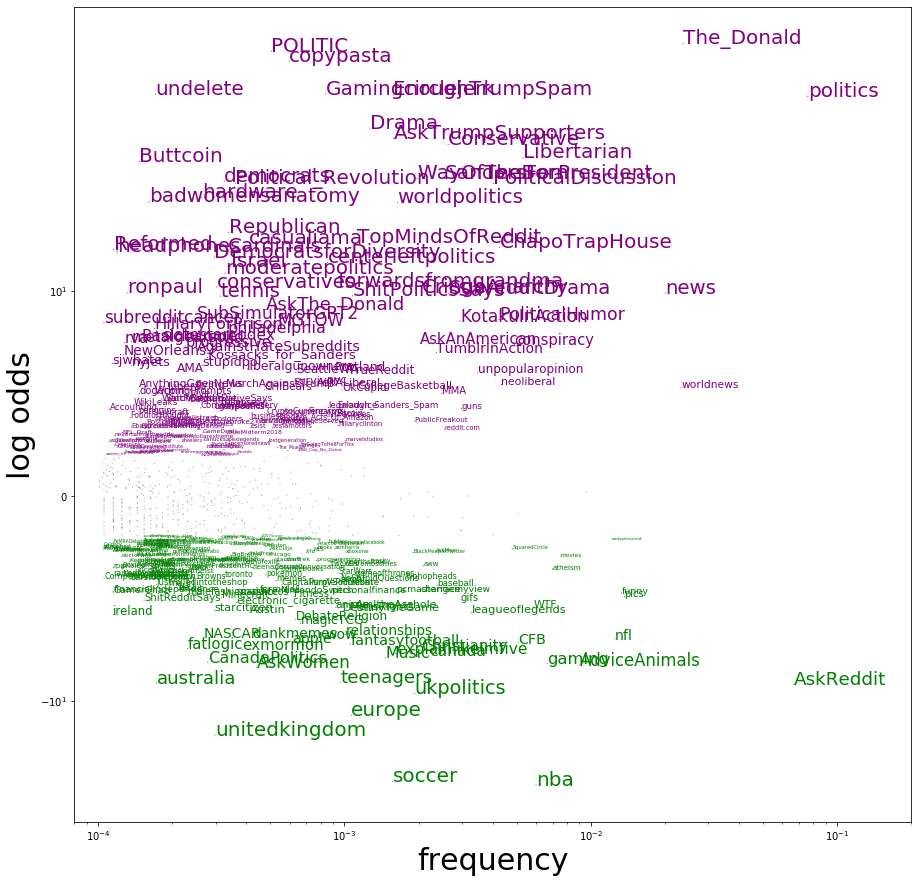

In [12]:
p,n=plot_log_odds(odd_freq,sig_val=1.96,min_freq=1e-4,max_odds=50,min_odds=-50)
plt.savefig('bad_actors_flip_counts/plots/bad_actors_partisans_log_odds_90_days.pdf', dpi=300,facecolor='w',bbox_inches='tight')